## ResNet Transefer_learning

In [10]:
# install tensorflow dataset
!pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# load the dataset
(ds_train, ds_test), ds_info=tfds.load(
    'rock_paper_scissors',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
print(ds_info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock

In [12]:
# 🧹 Step 3: Normalize and Batch the Data
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

batch_size = 64

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
base_model=tf.keras.applications.ResNet50V2(
    input_shape=(300,300,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable= False

model= tf.keras.Sequential([
    tf.keras.layers.Resizing(300,300),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [19]:
history=model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 968ms/step - accuracy: 0.8163 - loss: 0.6532 - val_accuracy: 0.7903 - val_loss: 0.4705
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.9922 - loss: 0.1499 - val_accuracy: 0.8038 - val_loss: 0.4015
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.9956 - loss: 0.0794 - val_accuracy: 0.8280 - val_loss: 0.3432
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - accuracy: 0.9998 - loss: 0.0564 - val_accuracy: 0.7984 - val_loss: 0.3728
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 319ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 0.7957 - val_loss: 0.3900
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 0.7957 - val_loss: 0.3972
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 0.7984 - val_loss: 0.3916
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 1.0000 - loss: 0.0211 - val_accu

Text(0.5, 1.0, 'Loss')

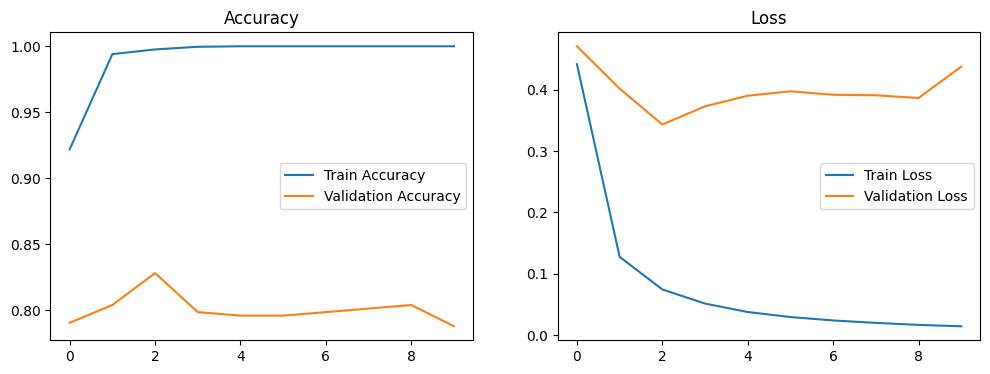

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Loss")

In [23]:
test_loss,test_acc = model.evaluate(ds_test)
print(f"Test Accuracy : {test_acc:.4f} Test Loss : {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7923 - loss: 0.4280
Test Accuracy : 0.7876 Test Loss : 0.4374


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


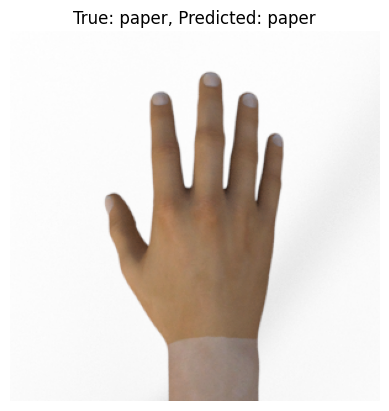

In [24]:
# 🔍 Step 8: Inference on a Random Test Image
import random
import tensorflow_datasets as tfds

# Load test data again without batching
raw_test_ds = tfds.load('rock_paper_scissors', split='test', as_supervised=True)

# Pick a random test sample
sample_list = list(raw_test_ds)
sample_image, sample_label = random.choice(sample_list)

# Preprocess image
input_image = tf.image.resize(sample_image, (300, 300)) / 255.0
input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension

# Predict
pred = model.predict(input_image)
predicted_class = tf.argmax(pred[0]).numpy()

# Class labels
class_names = ds_info.features['label'].names

# Display
plt.imshow(sample_image)
plt.title(f"True: {class_names[sample_label]}, Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()